In [342]:
import pandas as pd
import numpy as np
#import tensorflow as tf
import matplotlib.pyplot as plt
import time
import math
#import h5py
import re
from pandas.api.types import is_string_dtype, is_numeric_dtype
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import forest
from IPython.display import display
import os
from sklearn import metrics

from sklearn.tree import export_graphviz
import IPython,graphviz

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [347]:
data_size = 3e6

In [348]:
data_size

3000000.0

In [349]:
data_types = {'key': 'str', 
              'fare_amount': 'float32',
               #'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

In [350]:
df_raw = pd.read_csv('train.csv',nrows = data_size, parse_dates=['pickup_datetime'],dtype=data_types)

In [213]:
def display_all(df):
    with pd.option_context('display.max_rows',1000,'display.max_columns',1000):
        display(df)

In [214]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/bulldozers-raw')

AttributeError: module 'pyarrow' has no attribute 'compat'

In [215]:
display_all(df_raw.tail().T)

,499995,499996,499997,499998,499999
key,2015-05-07 18:45:12.0000004,2010-09-13 12:11:34.0000004,2014-08-25 00:22:20.0000001,2015-01-12 12:17:32.0000001,2010-04-12 23:46:58.0000002
fare_amount,7,13.7,25,6.5,4.9
pickup_datetime,2015-05-07 18:45:12,2010-09-13 12:11:34,2014-08-25 00:22:20,2015-01-12 12:17:32,2010-04-12 23:46:58
pickup_longitude,-73.9788,-74.0029,-73.9839,-73.9746,-73.9867
pickup_latitude,40.7667,40.7184,40.7256,40.7565,40.7222
dropoff_longitude,-73.9661,-74.0094,-73.8965,-73.9702,-73.9828
dropoff_latitude,40.7585,40.711,40.701,40.7648,40.7133
passenger_count,1,1,1,6,1


# delete Null

In [351]:
df_raw.isnull().sum()

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    23
dropoff_latitude     23
passenger_count       0
dtype: int64

In [352]:
df_raw = df_raw.dropna(axis=0,how='any')

In [353]:
len(df_raw)

2999977

## read test to find the boundry of the data

In [112]:
test = pd.read_csv('test.csv',parse_dates=["pickup_datetime"], dtype=datatypes)

In [113]:
display_all(test.describe(include='all'))

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914,9914,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
unique,9914,1753,NaN,NaN,NaN,NaN,NaN
top,2015-01-02 11:55:57.0000005,2011-12-13 22:00:00,NaN,NaN,NaN,NaN,NaN
freq,1,270,NaN,NaN,NaN,NaN,NaN
first,NaN,2009-01-01 11:04:24,NaN,NaN,NaN,NaN,NaN
last,NaN,2015-06-30 20:03:50,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,-73.974716,40.751041,-73.973656,40.751740,1.671273
std,NaN,NaN,0.042774,0.033541,0.039072,0.035435,1.278747
min,NaN,NaN,-74.252190,40.573143,-74.263245,40.568974,1.000000
25%,NaN,NaN,-73.992500,40.736125,-73.991249,40.735253,1.000000


# limit train set to be with the same scale of test set

In [354]:
BB = (-74.5, -72.8, 40.5, 41.8)
nyc_map = plt.imread('nyc_origin.png')

# load extra image to zoom in on NYC
BB_zoom = (-74.3, -73.7, 40.5, 40.9)
nyc_map_zoom = plt.imread('nyc_zoom.png')

## use box clean data

In [355]:
def clean(df,df_test,area,margin=0.1):
    # Delimiter lats and lons to NY only
    
    df=df[(BB[0] <= df['pickup_longitude']) & (df['pickup_longitude'] <= BB[1] )]
    df=df[(BB[0] <= df['dropoff_longitude']) & (df['dropoff_longitude'] <= BB[1])]
    df=df[(BB[2] <= df['pickup_latitude']) & (df['pickup_latitude'] <= BB[3])]
    df=df[(BB[2] <= df['dropoff_latitude']) & (df['dropoff_latitude'] <= BB[3])]
    
    assert df['pickup_longitude'].min()>BB[0] ,\
            df['pickup_longitude'].max()<BB[1]
    assert df['pickup_latitude'].min()>BB[2],\
            df['pickup_latitude'].max()<BB[3]
    assert df['dropoff_longitude'].min()>BB[0] ,\
            df['dropoff_longitude'].max()<BB[1]
    assert df['dropoff_latitude'].min()>BB[2],\
            df['dropoff_latitude'].max()<BB[3]          
    return df

In [356]:
df_raw = clean(df_raw,test,BB)

In [357]:
display_all(df_raw.describe(include='all'))

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2936477,2.936477e+06,2936477,2.936477e+06,2.936477e+06,2.936477e+06,2.936477e+06,2.936477e+06
unique,2936477,NaN,2364108,NaN,NaN,NaN,NaN,NaN
top,2012-01-21 03:56:08.0000001,NaN,2012-08-24 20:39:00,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,10,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,2009-01-01 00:00:46,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2015-06-30 23:59:03,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.132178e+01,NaN,-7.397503e+01,4.075108e+01,-7.397437e+01,4.075145e+01,1.684362e+00
std,NaN,9.692272e+00,NaN,3.850060e-02,2.954854e-02,3.764080e-02,3.272167e-02,1.307302e+00
min,NaN,-6.200000e+01,NaN,-7.448963e+01,4.050005e+01,-7.449991e+01,4.050005e+01,0.000000e+00
25%,NaN,6.000000e+00,NaN,-7.399228e+01,4.073657e+01,-7.399158e+01,4.073558e+01,1.000000e+00


# remove outlier

In [358]:
### remove fare_amount < 0 and pickup&dropoff at the same location

def remove(df):
    df=df[(0 < df['fare_amount'])] # & (df['fare_amount'] <= 250)]


    df=df[(df['dropoff_longitude'] != df['pickup_longitude'])]
    df=df[(df['dropoff_latitude'] != df['pickup_latitude'])]
    
    return df

In [359]:
df_raw = remove(df_raw)
df_raw.describe(include='all')

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2902070,2.902070e+06,2902070,2.902070e+06,2.902070e+06,2.902070e+06,2.902070e+06,2.902070e+06
unique,2902070,NaN,2341642,NaN,NaN,NaN,NaN,NaN
top,2012-01-21 03:56:08.0000001,NaN,2013-01-04 18:36:00,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,10,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,2009-01-01 00:00:46,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2015-06-30 23:59:03,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.131631e+01,NaN,-7.397549e+01,4.075098e+01,-7.397463e+01,4.075134e+01,1.684706e+00
std,NaN,9.577817e+00,NaN,3.584932e-02,2.780581e-02,3.492197e-02,3.119523e-02,1.307405e+00
min,NaN,1.000000e-02,NaN,-7.448963e+01,4.050183e+01,-7.449991e+01,4.050029e+01,0.000000e+00
25%,NaN,6.000000e+00,NaN,-7.399229e+01,4.073660e+01,-7.399158e+01,4.073561e+01,1.000000e+00


In [225]:
### visualize the data into the maps
def plot_data(df,BB,alpha=0.2,maps=nyc_map,s=10):
    fig, ax = plt.subplots(1,2)
    ax[0].scatter(df['pickup_longitude'],df['pickup_latitude'], alpha=alpha,c='r',s=s,zorder=1,marker='.')
    ax[0].set_xlim(BB[0],BB[1])
    ax[0].set_ylim(BB[2],BB[3]) 
    ax[0].xaxis.set_label_text('longitude')
    ax[0].yaxis.set_label_text('latitude')
    ax[0].set_title('pickup points')
    ax[0].imshow(maps, zorder=0, extent=BB)

    ax[1].scatter(df['dropoff_longitude'], df['dropoff_latitude'], zorder=1, alpha=alpha, c='r', s=s)
    ax[1].set_xlim((BB[0], BB[1]))
    ax[1].set_ylim((BB[2], BB[3]))
    ax[1].xaxis.set_label_text('longitude')
    ax[1].yaxis.set_label_text('latitude')
    ax[1].set_title('dropoff points')
    ax[1].imshow(maps, zorder=0, extent=BB)

    fig.set_size_inches(16,10)

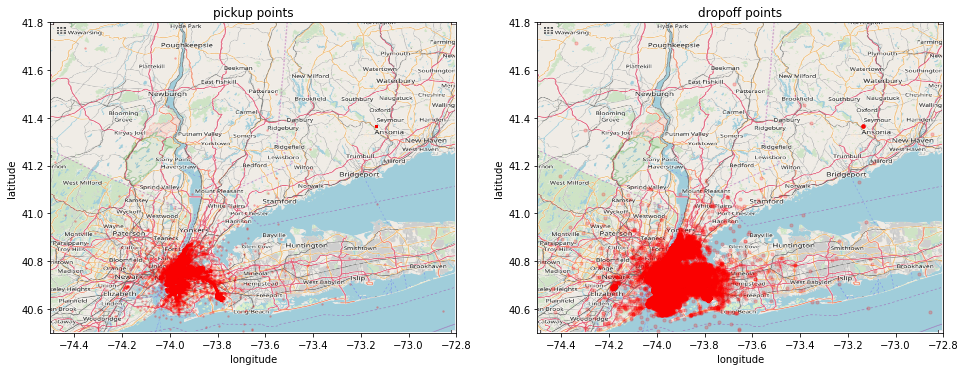

In [226]:
plot_data(df_raw,BB)

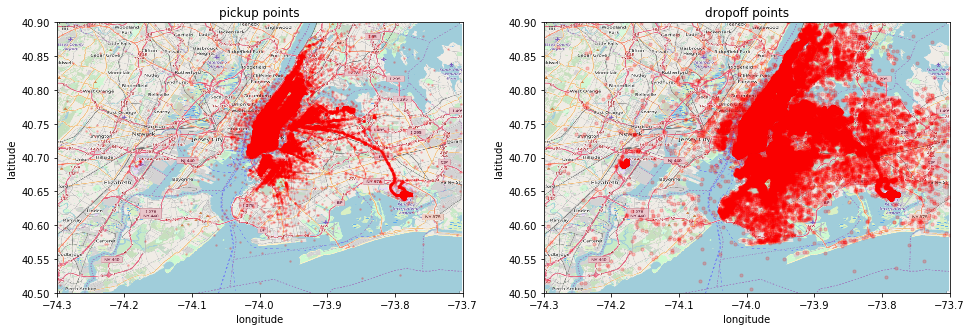

In [122]:
plot_data(df_raw,BB_zoom,maps=nyc_map_zoom)

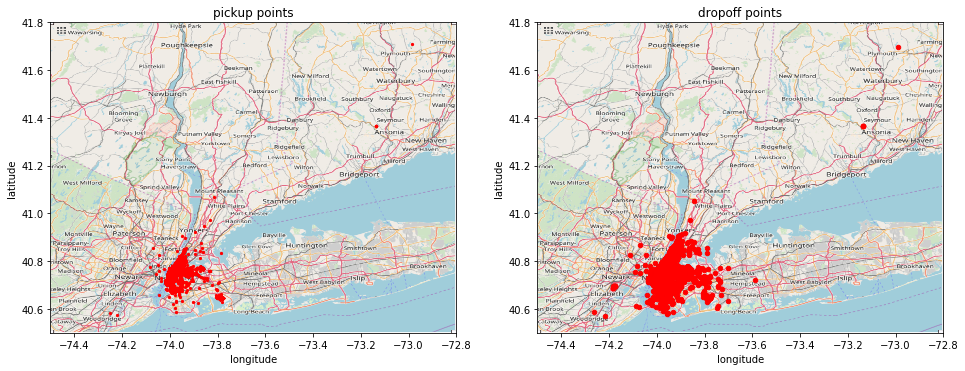

In [123]:
plot_data(test,BB,s=20,alpha=1.0)

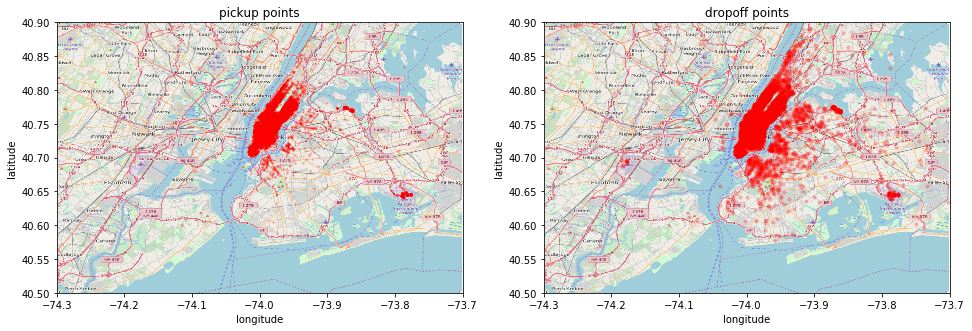

In [124]:
plot_data(test,BB_zoom,maps=nyc_map_zoom)

In [360]:
### remove the points in the water
nyc_mask = plt.imread('nyc_mask.png')
nyc_mask = nyc_mask[:,:,0] > 0.9

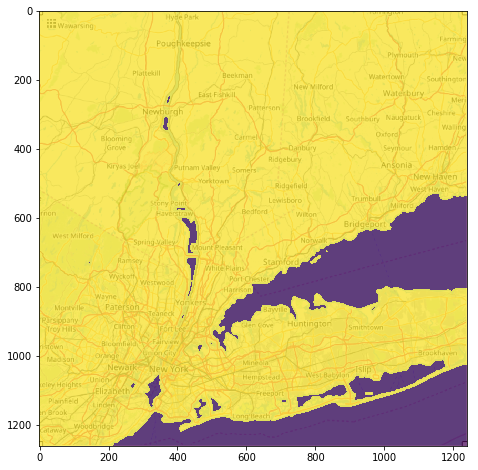

In [361]:
plt.figure(figsize=(8,8))
plt.imshow(nyc_map, zorder=0)
plt.imshow(nyc_mask, zorder=1, alpha=0.7);

In [362]:
# translate longitude/latitude coordinate into image xy coordinate
def lonlat_to_xy(longitude, latitude, dx, dy, BB):
    return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
           (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

In [364]:
pickup_x, pickup_y = lonlat_to_xy(df_raw.pickup_longitude, df_raw.pickup_latitude, 
                                  nyc_mask.shape[1], nyc_mask.shape[0], BB)
dropoff_x, dropoff_y = lonlat_to_xy(df_raw.dropoff_longitude, df_raw.dropoff_latitude, 
                                  nyc_mask.shape[1], nyc_mask.shape[0], BB)

idx = (nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x])
print("Number of trips in water: {}".format(np.sum(~idx)))

Number of trips in water: 548


In [367]:
len(idx),len(df_raw)

(2902070, 2901522)

In [232]:
idx.shape

(483705,)

In [366]:
df_raw = df_raw[idx]
df_raw.describe(include='all')

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2901522,2.901522e+06,2901522,2.901522e+06,2.901522e+06,2.901522e+06,2.901522e+06,2.901522e+06
unique,2901522,NaN,2341391,NaN,NaN,NaN,NaN,NaN
top,2012-01-21 03:56:08.0000001,NaN,2013-01-04 18:36:00,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,10,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,2009-01-01 00:00:46,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2015-06-30 23:59:03,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.131608e+01,NaN,-7.397552e+01,4.075099e+01,-7.397462e+01,4.075137e+01,1.684676e+00
std,NaN,9.577449e+00,NaN,3.573266e-02,2.774019e-02,3.479868e-02,3.113789e-02,1.307385e+00
min,NaN,1.000000e-02,NaN,-7.448963e+01,4.050386e+01,-7.449991e+01,4.050465e+01,0.000000e+00
25%,NaN,6.000000e+00,NaN,-7.399229e+01,4.073660e+01,-7.399158e+01,4.073562e+01,1.000000e+00


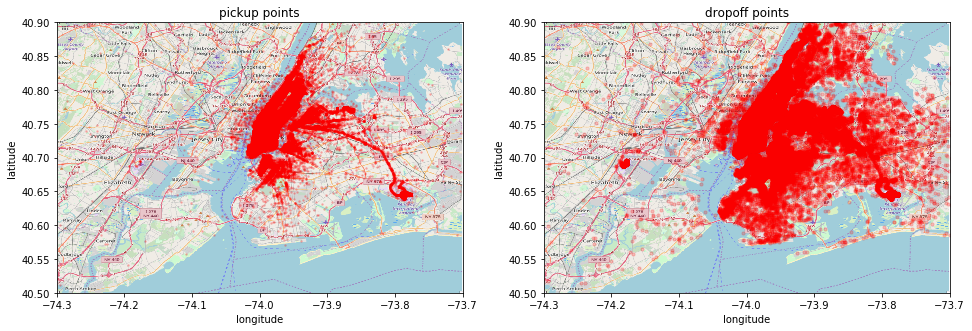

In [131]:
plot_data(df_raw,BB_zoom,maps=nyc_map_zoom)

# divide the timestamp

In [368]:
def add_datepart(df,fldname,drop=True,time=False):
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)

    
    pre = re.sub('[Dd]atetime','',fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[pre+n]= getattr(fld.dt,n.lower())
    df[pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname,axis=1,inplace=True)

In [369]:
add_datepart(df_raw,'pickup_datetime',time=True)

In [236]:
display_all(df_raw.tail().T)

,499995,499996,499997,499998,499999
key,2015-05-07 18:45:12.0000004,2010-09-13 12:11:34.0000004,2014-08-25 00:22:20.0000001,2015-01-12 12:17:32.0000001,2010-04-12 23:46:58.0000002
fare_amount,7,13.7,25,6.5,4.9
pickup_longitude,-73.9788,-74.0029,-73.9839,-73.9746,-73.9867
pickup_latitude,40.7667,40.7184,40.7256,40.7565,40.7222
dropoff_longitude,-73.9661,-74.0094,-73.8965,-73.9702,-73.9828
dropoff_latitude,40.7585,40.711,40.701,40.7648,40.7133
passenger_count,1,1,1,6,1
pickup_Year,2015,2010,2014,2015,2010
pickup_Month,5,9,8,1,4
pickup_Week,19,37,35,3,15


# turn string into categorical

In [370]:
def train_cat(df):
    for n,c in df.items():
        if is_string_dtype(c): 
            df[n]=c.astype('category').cat.as_ordered()

In [371]:
train_cat(df_raw)

In [239]:
display_all(df_raw.tail().T)

,499995,499996,499997,499998,499999
key,2015-05-07 18:45:12.0000004,2010-09-13 12:11:34.0000004,2014-08-25 00:22:20.0000001,2015-01-12 12:17:32.0000001,2010-04-12 23:46:58.0000002
fare_amount,7,13.7,25,6.5,4.9
pickup_longitude,-73.9788,-74.0029,-73.9839,-73.9746,-73.9867
pickup_latitude,40.7667,40.7184,40.7256,40.7565,40.7222
dropoff_longitude,-73.9661,-74.0094,-73.8965,-73.9702,-73.9828
dropoff_latitude,40.7585,40.711,40.701,40.7648,40.7133
passenger_count,1,1,1,6,1
pickup_Year,2015,2010,2014,2015,2010
pickup_Month,5,9,8,1,4
pickup_Week,19,37,35,3,15


# replace categorical with one-hot encode and pick up y

In [372]:
def fix_missing(df,col,name):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum(): df[name+'_na']=pd.isnull(col)  #pd.isnull returns True and False. Create a new column with True andFalse
        df[name]=col.fillna(col.median())  # fill the na values with median
def numericalize(df,col,name,max_n_cat):
    if not is_numeric_dtype(col) and (max_n_cat is None or col.nunique()>max_n_cat):
        df[name] = col.cat.codes+1
    #If it is not numeric and is a categorical type, we will replace the column with its code plus 1. By default pandas uses -1 for missing, so now missing will have an ID of 0 .
def drop_col(df):
    target = [0,6,-1]
    df.drop(df.columns[target],axis=1,inplace=True)   
    return df
def get_sample(df,n):
    idc = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idc].copy()

In [373]:
def ploc_df(df,y_fld=None,subset=None, na_dict=None,max_n_cat=None):
    if subset: df = get_sample(df,subset)
    df=df.copy()
    if y_fld is None:
        y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = df[y_fld].cat.codes
        y = df[y_fld].values
    df.drop(y_fld,axis=1,inplace=True)
    if na_dict is None: na_dict = {}
    for n,c in df.items(): na_dict = fix_missing(df, c, n)
    #if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    #df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    #if do_scale: res = res + [mapper]
    return res


In [374]:
df_raw_train = drop_col(df_raw)

In [244]:
is_numeric_dtype(df_raw_train['fare_amount'])

True

In [375]:
df,y,nas = ploc_df(df_raw_train,y_fld='fare_amount')

In [246]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=10)
m.fit(df, y)
m.score(df,y)

0.96855128204394236

In [247]:
display_all(df.head())

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_Year,pickup_Month,pickup_Week,pickup_Day,pickup_Dayofweek,pickup_Dayofyear,pickup_Is_month_end,pickup_Is_month_start,pickup_Is_quarter_end,pickup_Is_quarter_start,pickup_Is_year_end,pickup_Is_year_start,pickup_Hour,pickup_Minute,pickup_Second
0,-73.844315,40.721317,-73.841614,40.712276,2009,6,25,15,0,166,False,False,False,False,False,False,17,26,21
1,-74.016045,40.711304,-73.979271,40.782005,2010,1,1,5,1,5,False,False,False,False,False,False,16,52,16
2,-73.982735,40.761269,-73.991241,40.750561,2011,8,33,18,3,230,False,False,False,False,False,False,0,35,0
3,-73.987129,40.733143,-73.991570,40.758091,2012,4,16,21,5,112,False,False,False,False,False,False,4,30,42
4,-73.968094,40.768009,-73.956657,40.783764,2010,3,10,9,1,68,False,False,False,False,False,False,7,51,0


# separate a validation set with the size of test 9914

In [376]:
def divide(df,idx,val_size): 
    df = df.copy()
    if type(df)==np.ndarray:
        df = df[idx]
    else:
        df=df.iloc[idx]
    df_val=df[:val_size]
    df_train=df[val_size:]
    return df_train, df_val

In [377]:
idx = np.random.permutation(len(df))

In [378]:
X_train,X_val = divide(df,idx,len(test))

In [385]:
y_train,y_val = divide(y,idx,len(test))

In [386]:
len(X_train),len(X_val),len(df),len(y_train),len(y_val)

(2891608, 9914, 2901522, 2891608, 9914)

# random forest

## baseline

In [258]:
def rmse(x,y): return np.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train),y_train),rmse(m.predict(X_val),y_val),
              m.score(X_train, y_train), m.score(X_val, y_val)]
    if hasattr(m,'oob_score_'): res.append(m.oob_score_)
    print(res)

In [259]:
m= RandomForestRegressor(n_jobs=-1,n_estimators=10)
%time m.fit(X_train,y_train)
print_score(m)

Wall time: 17.5 s
[1.7051951877275939, 3.4321935993242532, 0.96869804176215424, 0.86346857647266662]


In [ ]:
#overfitting badly

## expedite the training with subset

In [285]:
df_tru, y_tru, nas = ploc_df(df_raw_train,y_fld='fare_amount',subset=40000)
idx2 = np.random.permutation(40000)
X_train,_ = divide(df_tru,idx2,10000)
y_train,_ = divide(y_tru,idx2,10000)

In [286]:
len(X_train),len(y_train),len(df_tru),len(y_tru)

(30000, 30000, 40000, 40000)

In [287]:
m = RandomForestRegressor(n_jobs=-1,n_estimators=10)
%time m.fit(X_train,y_train)
print_score(m)

Wall time: 535 ms
[1.797735221648856, 3.7538075157083721, 0.96432911572869384, 0.8366823721602572]


## single tree

In [289]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[6.262799706461232, 6.0799315325000389, 0.56708815780216915, 0.57156352104986441]


In [299]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.0, 5.2918999055631195, 1.0, 0.67542706226187488]


# Bagging (ensembling)

In [300]:
# ten trees
m = RandomForestRegressor(n_jobs=-1,n_estimators=10)
%time m.fit(X_train,y_train)
print_score(m)

Wall time: 544 ms
[1.8016050071110603, 3.819486823966558, 0.96417538092059873, 0.83091733022734104]


In [301]:
preds = np.stack([t.predict(X_val) for t in m.estimators_])  #each tree is stored in the attribute estimators_

In [309]:
preds[:,0],np.mean(preds[:,0]),y_val[0]

(array([ 13. ,   9. ,   8.5,  20.5,   8. ,   8. ,  20.5,  13.5,  13.5,   8. ]),
 12.25,
 11.5)

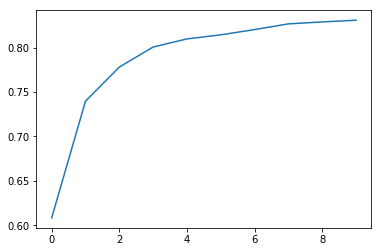

In [315]:
plt.plot([metrics.r2_score(y_val,np.mean(preds[:i+1],axis=0)) for i in range(10)])

In [ ]:
# not help a lot when estimators is over 8

In [319]:
m = RandomForestRegressor(n_jobs=-1,n_estimators=80)
%time m.fit(X_train,y_train)
print_score(m)

Wall time: 3.43 s
[1.4896701707328011, 3.5557568190361626, 0.97550696156983951, 0.85346101894286475]


## out of Bagging

In [320]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[1.545727143854094, 3.5832333393560343, 0.97362890958193204, 0.85118755757148257, 0.81264338092346244]


# Reduce overfitting

## sub-sampling

In [330]:
X_train,X_val = divide(df,idx,len(test))

In [331]:
y_train,y_val = divide(y,idx,len(test))

In [332]:
def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

In [333]:
set_rf_samples(30000) #Just as before, we use 20,000 of them in our training set (before it was out of 30,000, this time it is out of 389,125).

In [334]:
m= RandomForestRegressor(n_jobs=-1,n_estimators=10,oob_score=True)
%time m.fit(X_train,y_train)
print_score(m)

Wall time: 3.1 s
[3.9073792138944814, 3.5378553174251528, 0.83564064256837178, 0.85493280933886839, 0.81545451262752]


In [335]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[3.7463915849936735, 3.4431066652642861, 0.84890515428128754, 0.86259896048924944, 0.82887989767006787]


In [382]:
# reset bootstrapping to see other over-fitting

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

In [383]:
reset_rf_samples()

In [340]:
# build baseline
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[1.4643578533150112, 3.3199281670100964, 0.97691564458075386, 0.87225425651395116, 0.83222488627883207]


In [387]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[2.2364004563773254, 3.376833740995278, 0.94547755542033585, 0.87362540910278508, 0.87064308710389093]
